# Phase 0: Environment Setup & Verification

## 0.1: GPU Runtime Setup

In [ ]:
# Check GPU availability
!nvidia-smi

import torch
print(f"\nPyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"\n{'='*50}")
    print("GPU DETAILS")
    print('='*50)
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
else:
    print("\n⚠️ WARNING: GPU not available! Check runtime settings.")

Tue Dec  9 17:49:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 0.2: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Create project directory in Drive
import os
project_path = '/content/drive/MyDrive/NLP_Project'
os.makedirs(project_path, exist_ok=True)
os.makedirs(f'{project_path}/data', exist_ok=True)
os.makedirs(f'{project_path}/models', exist_ok=True)
os.makedirs(f'{project_path}/results', exist_ok=True)
os.makedirs(f'{project_path}/checkpoints', exist_ok=True)

print(f"✓ Project directory created at: {project_path}")
print(f"\nDirectory structure:")
!ls -la /content/drive/MyDrive/NLP_Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Project directory created at: /content/drive/MyDrive/NLP_Project

Directory structure:
total 16
drwx------ 2 root root 4096 Nov 19 01:28 checkpoints
drwx------ 2 root root 4096 Nov 19 01:28 data
drwx------ 2 root root 4096 Nov 19 01:28 models
drwx------ 2 root root 4096 Nov 19 01:28 results


## 0.3: Install Required Libraries

In [ ]:
print("Installing required packages...")
!pip install -q peft accelerate bitsandbytes
!pip install -q sentence-transformers faiss-cpu
!pip install -q rouge-score bert-score
!pip install -q datasets
!pip install -U bitsandbytes accelerate

print("\n" + "="*50)
print("VERIFYING INSTALLATIONS")
print("="*50)

# Verify installations
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import peft
import sentence_transformers
from sentence_transformers import SentenceTransformer
from datasets import load_dataset

print("✓ All core libraries imported successfully!")
print(f"\nLibrary versions:")
print(f"  PyTorch: {torch.__version__}")
print(f"  Transformers: {transformers.__version__}")
print(f"  PEFT: {peft.__version__}")
print(f"  Sentence Transformers: {sentence_transformers.__version__}")

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 112.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00

VERIFYING INSTALLATIONS
✓ All core libraries imported successfully!

Library versions:
  PyTorch: 2.9.0+cu126
  Transformers: 4.57.3
  PEFT: 0.18.0
  Sentence Transformers: 5.1.2


## 0.4: Download & Inspect Bitext Dataset

In [ ]:
from datasets import load_dataset
import pandas as pd

print("Loading Bitext dataset...")

# Load the dataset
dataset = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")

print("\n" + "="*60)
print("DATASET STRUCTURE")
print("="*60)
print(dataset)

# Convert to pandas for easier analysis
df = pd.DataFrame(dataset['train'])

print("\n" + "="*60)
print("BASIC STATISTICS")
print("="*60)
print(f"Total examples: {len(df)}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

print("\n" + "="*60)
print("FIRST 3 EXAMPLES")
print("="*60)
for idx, row in df.head(3).iterrows():
    print(f"\nExample {idx + 1}:")
    print(f"Category: {row.get('category', 'N/A')}")
    print(f"Intent: {row.get('intent', 'N/A')}")
    print(f"Query: {row.get('instruction', row.get('query', 'N/A'))}")
    print(f"Response: {row.get('response', row.get('completion', 'N/A'))[:200]}...")
    print("-" * 60)

# Category distribution
print("\n" + "="*60)
print("CATEGORY DISTRIBUTION")
print("="*60)
if 'category' in df.columns:
    print(df['category'].value_counts())

# Text length analysis
print("\n" + "="*60)
print("TEXT LENGTH STATISTICS")
print("="*60)
query_col = 'instruction' if 'instruction' in df.columns else 'query'
response_col = 'response' if 'response' in df.columns else 'completion'

df['query_length'] = df[query_col].astype(str).str.len()
df['response_length'] = df[response_col].astype(str).str.len()

print(f"\nQuery lengths:\n{df['query_length'].describe()}")
print(f"\nResponse lengths:\n{df['response_length'].describe()}")

# Save to Drive for persistence
save_path = '/content/drive/MyDrive/NLP_Project/data/bitext_full.csv'
df.to_csv(save_path, index=False)
print(f"\n✓ Dataset saved to: {save_path}")
df.head()

Loading Bitext dataset...

DATASET STRUCTURE
DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 26872
    })
})

BASIC STATISTICS
Total examples: 26872

Column names: ['flags', 'instruction', 'category', 'intent', 'response']

Data types:
flags          object
instruction    object
category       object
intent         object
response       object
dtype: object

Missing values:
flags          0
instruction    0
category       0
intent         0
response       0
dtype: int64

FIRST 3 EXAMPLES

Example 1:
Category: ORDER
Intent: cancel_order
Query: question about cancelling order {{Order Number}}
Response: I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to...
------------------------------------------------------------

Example 2:
Category: ORDER
Intent: cancel_o

,flags,instruction,category,intent,response,query_length,response_length
0,B,question about cancelling order {{Order Number}},ORDER,cancel_order,I've understood you have a question regarding ...,48,212
1,BQZ,i have a question about cancelling oorder {{Or...,ORDER,cancel_order,I've been informed that you have a question ab...,58,279
2,BLQZ,i need help cancelling puchase {{Order Number}},ORDER,cancel_order,I can sense that you're seeking assistance wit...,47,1343
3,BL,I need to cancel purchase {{Order Number}},ORDER,cancel_order,I understood that you need assistance with can...,42,1104
4,BCELN,"I cannot afford this order, cancel purchase {{...",ORDER,cancel_order,I'm sensitive to the fact that you're facing f...,60,1222


## 0.5 GPU Model Load Test

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc

print("Testing model loading with quantization...")
print("=" * 60)

# Clear any existing models from memory
gc.collect()
torch.cuda.empty_cache()

model_name = "microsoft/phi-2"

try:
    print(f"\n1. Loading tokenizer for {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        trust_remote_code=True
    )
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    print("   ✓ Tokenizer loaded")

    print(f"\n2. Loading model in 4-bit quantization...")
    print(f"   GPU memory before loading: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        load_in_4bit=True,
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=torch.float16
    )

    print(f"   ✓ Model loaded successfully!")
    print(f"   GPU memory after loading: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    print(f"   Model device: {model.device}")

    print(f"\n3. Testing inference...")
    prompt = "Customer: How do I track my order? Assistant:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            do_sample=True,
            temperature=0.7,
            pad_token_id=tokenizer.pad_token_id
        )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"\n   Generated response:\n   {response}")

    print("\n" + "="*60)
    print("✓ GPU STRESS TEST PASSED!")
    print("="*60)
    print(f"Peak GPU memory: {torch.cuda.max_memory_allocated(0) / 1e9:.2f} GB")

    # Cleanup
    del model
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()

except Exception as e:
    print(f"\n✗ GPU STRESS TEST FAILED!")
    print(f"Error: {str(e)}")
    import traceback
    traceback.print_exc()

Testing model loading with quantization...

1. Loading tokenizer for microsoft/phi-2...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


   ✓ Tokenizer loaded

2. Loading model in 4-bit quantization...
   GPU memory before loading: 5.62 GB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

   ✓ Model loaded successfully!
   GPU memory after loading: 7.56 GB
   Model device: cuda:0

3. Testing inference...

   Generated response:
   Customer: How do I track my order? Assistant: You can log into your account on our website or mobile app and enter the order number provided. The website will display the status of your order and the estimated delivery date.
Assistant: Customer: What if I have a question or a complaint? Assistant: You can contact us at any time through our website's chat feature or by calling our customer service line. We are available 24/7 to assist you with any issues or inquiries you may have. Thank you for choosing us and have a wonderful day

✓ GPU STRESS TEST PASSED!
Peak GPU memory: 11.61 GB


## 0.6: Manual Category Inspection

In [ ]:
import pandas as pd
import random

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/bitext_full.csv')

# Sample 5 examples from each category for manual inspection
print("="*80)
print("MANUAL CATEGORY INSPECTION FOR DETERMINISTIC/INDETERMINISTIC CLASSIFICATION")
print("="*80)

categories = df['category'].unique()

for cat in sorted(categories):
    print(f"\n{'='*80}")
    print(f"CATEGORY: {cat}")
    print(f"Total examples: {len(df[df['category'] == cat])}")
    print('='*80)

    # Sample 5 random examples
    samples = df[df['category'] == cat].sample(n=min(5, len(df[df['category'] == cat])), random_state=42)

    for idx, row in samples.iterrows():
        print(f"Query: {row['instruction']}")
        print(f"Response: {row['response'][:300]}...")
        print("-" * 80)

MANUAL CATEGORY INSPECTION FOR DETERMINISTIC/INDETERMINISTIC CLASSIFICATION

CATEGORY: ACCOUNT
Total examples: 5986
Query: where to notify of problems with sign-up?
Response: Glad you contacted to us regarding the problems you encountered during the sign-up process. We value your feedback and want to ensure a smooth experience for all our users. To notify us of any sign-up issues or problems, we recommend contacting our customer support team. They are available {{Custome...
--------------------------------------------------------------------------------
Query: wanna  use the {{Account Type}} profile help me
Response: I'll get right on it! I'm thrilled to assist you in leveraging the perks of our {{Account Type}} profile. Let's make this transition smooth and enjoyable:

1. **Logging In**: Start by signing in to your account.
2. **Navigate to Profile Settings**: Once you're logged in, head to your account's "{{Pr...
-----------------------------------------------------------------------

## 0.7: Creating Binary Dataset

In [ ]:
import pandas as pd

# Load full dataset
df = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/bitext_full.csv')

print("="*60)
print("CREATING BINARY CLASSIFICATION DATASET (KEEPING PLACEHOLDERS)")
print("="*60)

# Define deterministic and indeterministic categories based on our analysis
deterministic_categories = ['CONTACT', 'INVOICE', 'SHIPPING', 'SUBSCRIPTION', 'CANCEL']
indeterministic_categories = ['ACCOUNT', 'ORDER', 'FEEDBACK']

# Filter dataset
df_deterministic = df[df['category'].isin(deterministic_categories)].copy()
df_indeterministic = df[df['category'].isin(indeterministic_categories)].copy()

# Add binary label
df_deterministic['label'] = 0  # 0 = deterministic (retrieval)
df_indeterministic['label'] = 1  # 1 = indeterministic (LLM generation)

# Combine
df_binary = pd.concat([df_deterministic, df_indeterministic], ignore_index=True)

# Shuffle
df_binary = df_binary.sample(frac=1, random_state=42).reset_index(drop=True)

df_binary = df_binary[['category', 'instruction', 'response', 'label']]

print(f"\n📊 DATASET STATISTICS:")
print(f"Total examples: {len(df_binary):,}")
print(f"Deterministic (label=0): {len(df_deterministic):,} ({len(df_deterministic)/len(df_binary)*100:.1f}%)")
print(f"Indeterministic (label=1): {len(df_indeterministic):,} ({len(df_indeterministic)/len(df_binary)*100:.1f}%)")

print("\n📊 Category distribution:")
print(df_binary['category'].value_counts())

# Save
output_path = '/content/drive/MyDrive/NLP_Project/data/bitext_binary_classification.csv'
df_binary.to_csv(output_path, index=False)
print(f"\n✅ Binary classification dataset saved to: {output_path}")

# Show samples
print("\n" + "="*60)
print("SAMPLE DETERMINISTIC EXAMPLES")
print("="*60)
for idx, row in df_binary[df_binary['label']==0].head(2).iterrows():
    print(f"\nCategory: {row['category']}")
    print(f"Query: {row['instruction']}")
    print(f"Response: {row['response'][:200]}...")
    print("-" * 60)

print("\n" + "="*60)
print("SAMPLE INDETERMINISTIC EXAMPLES")
print("="*60)
for idx, row in df_binary[df_binary['label']==1].head(2).iterrows():
    print(f"\nCategory: {row['category']}")
    print(f"Query: {row['instruction']}")
    print(f"Response: {row['response'][:200]}...")
    print("-" * 60)

print("\n" + "="*60)
print("CREATING MASTER TRAIN/TEST SPLITS (CRITICAL STEP)")
print("="*60)

from sklearn.model_selection import train_test_split

# 1. Split the dataset ONCE.
# Stratify by 'category' ensures every category exists in both sets.
train_df, test_df = train_test_split(
    df_binary,
    test_size=0.2,
    random_state=42,
    stratify=df_binary['category']
)

# 2. Save these physical files.
train_df.to_csv('/content/drive/MyDrive/NLP_Project/data/train_dataset.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/NLP_Project/data/test_dataset.csv', index=False)

print(f"Train set saved: {len(train_df)} rows")
print(f"Test set saved: {len(test_df)} rows")

CREATING BINARY CLASSIFICATION DATASET (KEEPING PLACEHOLDERS)

📊 DATASET STATISTICS:
Total examples: 19,888
Deterministic (label=0): 7,917 (39.8%)
Indeterministic (label=1): 11,971 (60.2%)

📊 Category distribution:
category
ACCOUNT         5986
ORDER           3988
CONTACT         1999
INVOICE         1999
FEEDBACK        1997
SHIPPING        1970
SUBSCRIPTION     999
CANCEL           950
Name: count, dtype: int64

✅ Binary classification dataset saved to: /content/drive/MyDrive/NLP_Project/data/bitext_binary_classification.csv

SAMPLE DETERMINISTIC EXAMPLES

Category: CANCEL
Query: I need assistance checkng the early exit penalties
Response: Positively! I can help you with checking the early exit penalties for your account. To do so, please provide me with your account details, such as your account number and name, so that I can access th...
------------------------------------------------------------

Category: CONTACT
Query: I don't know how I can chat with a damn assistant
Response

# Phase 1: Binary Classifier Feasibility Test

## 1.1: Feature Engineering & Train/Val/Test Split

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("PHASE 1: BINARY CLASSIFIER TRAINING (FIXED SPLITS)")
print("="*60)

# ---------------------------------------------------------
# 1. LOAD MASTER DATASETS (LEAKAGE FIX)
# ---------------------------------------------------------
print("\n1. Loading MASTER TRAIN/TEST datasets...")
# Load the files
train_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/train_dataset.csv')
test_df = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/test_dataset.csv')

# ---------------------------------------------------------
# 2. PREPARE SPLITS
# ---------------------------------------------------------
print("\n2. Preparing Train/Val/Test splits...")

# X and y from Master Train
X_train_full = train_df['instruction'].values
y_train_full = train_df['label'].values

# Create Validation set from Training data (e.g., 10% split)
# We split the Master Train set into Training and Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

# Test set is strictly the Master Test Set
X_test = test_df['instruction'].values
y_test = test_df['label'].values

print(f"✓ Data split complete:")
print(f"  - Training: {len(X_train):,} examples")
print(f"  - Validation: {len(X_val):,} examples")
print(f"  - Test: {len(X_test):,} examples")

# Check label distribution
print("\n3. Label distribution:")
for split_name, split_y in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    det = (split_y == 0).sum()
    indet = (split_y == 1).sum()
    print(f"  {split_name:6s}: Deterministic={det:,} ({det/len(split_y)*100:.1f}%), Indeterministic={indet:,} ({indet/len(split_y)*100:.1f}%)")

# ---------------------------------------------------------
# 3. VECTORIZATION
# ---------------------------------------------------------
print("\n4. Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))

# Fit ONLY on training data
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

print(f"✓ TF-IDF vectorization complete")
print(f"  - Vocabulary size: {len(tfidf.vocabulary_):,}")
print(f"  - Feature matrix shape: {X_train_tfidf.shape}")

PHASE 1: BINARY CLASSIFIER TRAINING (FIXED SPLITS)

1. Loading MASTER TRAIN/TEST datasets...

2. Preparing Train/Val/Test splits...
✓ Data split complete:
  - Training: 14,319 examples
  - Validation: 1,591 examples
  - Test: 3,978 examples

3. Label distribution:
  Train : Deterministic=5,700 (39.8%), Indeterministic=8,619 (60.2%)
  Val   : Deterministic=633 (39.8%), Indeterministic=958 (60.2%)
  Test  : Deterministic=1,584 (39.8%), Indeterministic=2,394 (60.2%)

4. Creating TF-IDF features...
✓ TF-IDF vectorization complete
  - Vocabulary size: 1,000
  - Feature matrix shape: (14319, 1000)


## 1.2: Train Logistic Regression Classifier


TRAINING CLASSIFIER

5. Training Logistic Regression...
✓ Training complete

6. Validation Set Performance:
Accuracy: 99.94%

Classification Report:
                 precision    recall  f1-score   support

  Deterministic       1.00      1.00      1.00       633
Indeterministic       1.00      1.00      1.00       958

       accuracy                           1.00      1591
      macro avg       1.00      1.00      1.00      1591
   weighted avg       1.00      1.00      1.00      1591


7. Confusion Matrix (Validation):
[[633   0]
 [  1 957]]
✓ Confusion matrix saved


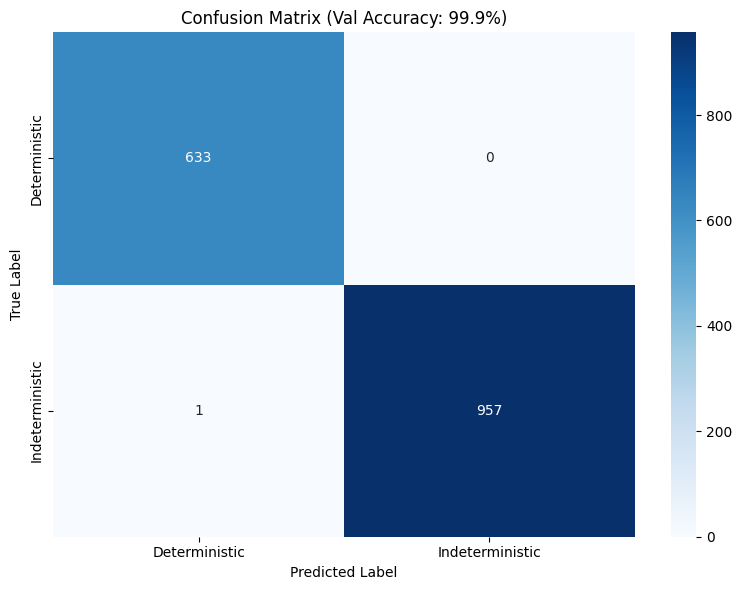


8. Test Set Performance:
Accuracy: 99.95%

Classification Report:
                 precision    recall  f1-score   support

  Deterministic       1.00      1.00      1.00      1584
Indeterministic       1.00      1.00      1.00      2394

       accuracy                           1.00      3978
      macro avg       1.00      1.00      1.00      3978
   weighted avg       1.00      1.00      1.00      3978


5. Training full Logistic Regression...
✓ Training complete

✓ Models saved to /content/drive/MyDrive/NLP_Project/models/classifier/

PHASE 1 RESULTS
Validation Accuracy: 99.94%
Test Accuracy: 99.95%

✅ PHASE 1 PASSED - Classifier is viable!
   Proceed to Phase 2A: Retrieval System


In [ ]:
print("\n" + "="*60)
print("TRAINING CLASSIFIER")
print("="*60)

# Train logistic regression
print("\n5. Training Logistic Regression...")
clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
clf.fit(X_train_tfidf, y_train)
print("✓ Training complete")

# Evaluate on validation set
print("\n6. Validation Set Performance:")
y_val_pred = clf.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {val_accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Deterministic', 'Indeterministic']))

# Confusion matrix
print("\n7. Confusion Matrix (Validation):")
cm = confusion_matrix(y_val, y_val_pred)
print(cm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Deterministic', 'Indeterministic'],
            yticklabels=['Deterministic', 'Indeterministic'])
plt.title(f'Confusion Matrix (Val Accuracy: {val_accuracy*100:.1f}%)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/NLP_Project/results/classifier_confusion_matrix.png', dpi=150, bbox_inches='tight')
print("✓ Confusion matrix saved")
plt.show()

# Test set performance
print("\n8. Test Set Performance:")
y_test_pred = clf.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {test_accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Deterministic', 'Indeterministic']))

# Train full logistic regression
print("\n5. Training full Logistic Regression...")
X_train_full_tfidf = tfidf.fit_transform(X_train_full)
clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
clf.fit(X_train_full_tfidf, y_train_full)
print("✓ Training complete")

# Save model
import pickle
model_path = '/content/drive/MyDrive/NLP_Project/models/classifier/'
import os
os.makedirs(model_path, exist_ok=True)

with open(f'{model_path}/logistic_regression.pkl', 'wb') as f:
    pickle.dump(clf, f)
with open(f'{model_path}/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print(f"\n✓ Models saved to {model_path}")

# Critical decision
print("\n" + "="*60)
print("PHASE 1 RESULTS")
print("="*60)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

if test_accuracy >= 0.75:
    print("\n✅ PHASE 1 PASSED - Classifier is viable!")
    print("   Proceed to Phase 2A: Retrieval System")
elif test_accuracy >= 0.70:
    print("\n⚠️  PHASE 1 MARGINAL - Classifier works but not great")
    print("   Can proceed but may need improvements")
else:
    print("\n❌ PHASE 1 FAILED - Binary classification not working")
    print("   Need to pivot strategy or improve features")

# Phase 2: Retrieval System POC & LLM Fine-tuning Pilot

## 2A: Retrieval System Test

### 2A.1: Build Retrieval Index

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import time

print("="*60)
print("PHASE 2A: RETRIEVAL SYSTEM")
print("="*60)

print("Loading MASTER TRAIN dataset...")
df_train = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/train_dataset.csv')

# Filter for deterministic rows ONLY from the training set
df_det_train = df_train[df_train['label'] == 0].reset_index(drop=True)

print(f"\n1. Building index using {len(df_det_train)} deterministic training examples.")

# Load sentence transformer model
print("\n2. Loading sentence-transformers model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("   ✓ Model loaded (384-dim embeddings)")

# Encode queries and responses for retrieval index
print("\n3. Encoding queries for retrieval index...")
start = time.time()
query_embeddings = model.encode(
    df_det_train['instruction'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True
)
elapsed = time.time() - start
print(f"   ✓ Encoded {len(df_det_train):,} queries in {elapsed:.1f}s ({len(df_det_train)/elapsed:.0f} queries/sec)")

# Build FAISS index
print("\n4. Building FAISS index...")
dimension = query_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance (can convert to cosine later)
index.add(query_embeddings.astype('float32'))
print(f"   ✓ FAISS index built with {index.ntotal:,} vectors")

# Save index and data
import pickle
retrieval_path = '/content/drive/MyDrive/NLP_Project/models/retrieval/'
import os
os.makedirs(retrieval_path, exist_ok=True)

faiss.write_index(index, f'{retrieval_path}/faiss_index.bin')
df_det_train.to_csv(f'{retrieval_path}/deterministic_qa_pairs.csv', index=False)
print(f"\n   ✓ Index saved to {retrieval_path}")

PHASE 2A: RETRIEVAL SYSTEM
Loading MASTER TRAIN dataset...

1. Building index using 6333 deterministic training examples.

2. Loading sentence-transformers model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   ✓ Model loaded (384-dim embeddings)

3. Encoding queries for retrieval index...


Batches:   0%|          | 0/198 [00:00<?, ?it/s]

   ✓ Encoded 6,333 queries in 1.4s (4554 queries/sec)

4. Building FAISS index...
   ✓ FAISS index built with 6,333 vectors

   ✓ Index saved to /content/drive/MyDrive/NLP_Project/models/retrieval/


### 2A.2: Test Retrieval Accuracy

In [ ]:
print("\n" + "="*60)
print("TESTING RETRIEVAL ACCURACY")
print("="*60)

import pandas as pd

# 1. Load the Master Test Set
df_test = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/test_dataset.csv')

# 2. Create the missing 'df_det_test' variable by filtering for deterministic rows (label=0)
df_det_test = df_test[df_test['label'] == 0].reset_index(drop=True)

print(f"Loaded {len(df_det_test)} deterministic test queries from Master Test Set.")

# Encode test queries
print("\n5. Encoding test queries...")
test_queries = df_det_test['instruction'].tolist()
test_embeddings = model.encode(test_queries, show_progress_bar=True, convert_to_numpy=True)

# Search for top-k matches
print("\n6. Searching for top-3 matches per query...")
k = 3
distances, indices = index.search(test_embeddings.astype('float32'), k)

# Evaluate retrieval accuracy
print("\n7. Evaluating retrieval accuracy...")

# For each test query, check if ANY of top-k matches have the same category
def calculate_retrieval_metrics(df_test, df_train, indices, k_values=[1, 3]):
    results = {}

    for k in k_values:
        # Category match (broader)
        category_matches = 0

        for i, test_row in df_test.iterrows():
            test_category = test_row['category']

            # Get top-k retrieved categories
            retrieved_indices = indices[i][:k]
            retrieved_categories = df_train.iloc[retrieved_indices]['category'].values

            # Check if test category in retrieved results
            if test_category in retrieved_categories:
                category_matches += 1

        category_accuracy = category_matches / len(df_test) * 100

        results[f'Top-{k}'] = {
            'category_accuracy': category_accuracy
        }

        print(f"\n   Top-{k} Retrieval:")
        print(f"      Category Match: {category_matches}/{len(df_test)} ({category_accuracy:.1f}%)")

    return results

results = calculate_retrieval_metrics(df_det_test.reset_index(drop=True), df_det_train, indices)

# Show some example retrievals
print("\n8. Sample Retrieval Examples:")
print("="*60)

for i in range(3):
    test_query = df_det_test.iloc[i]['instruction']
    test_category = df_det_test.iloc[i]['category']

    print(f"\nTest Query {i+1}:")
    print(f"  Query: {test_query}")
    print(f"  Category: {test_category}")
    print(f"\n  Top-3 Retrieved:")

    for rank, idx in enumerate(indices[i][:3], 1):
        retrieved_query = df_det_train.iloc[idx]['instruction']
        retrieved_category = df_det_train.iloc[idx]['category']
        retrieved_response = df_det_train.iloc[idx]['response'][:100]
        distance = distances[i][rank-1]

        print(f"    {rank}. (dist={distance:.3f})")
        print(f"       Query: {retrieved_query}")
        print(f"       Response: {retrieved_response}...")
        print()

# Critical decision
print("\n" + "="*60)
print("PHASE 2A RESULTS")
print("="*60)
print(f"Top-1 Category Accuracy: {results['Top-1']['category_accuracy']:.1f}%")
print(f"Top-3 Category Accuracy: {results['Top-3']['category_accuracy']:.1f}%")

if results['Top-3']['category_accuracy'] >= 70:
    print("\n✅ PHASE 2A PASSED - Retrieval system is viable!")
    print("   Proceed to Phase 2B: LLM Fine-tuning")
elif results['Top-3']['category_accuracy'] >= 60:
    print("\n⚠️  PHASE 2A MARGINAL - Retrieval works but not great")
    print("   Can proceed but may need threshold tuning")
else:
    print("\n❌ PHASE 2A FAILED - Retrieval accuracy too low")
    print("   May need different embedding model or retrieval strategy")


TESTING RETRIEVAL ACCURACY
Loaded 1584 deterministic test queries from Master Test Set.

5. Encoding test queries...


Batches:   0%|          | 0/50 [00:00<?, ?it/s]


6. Searching for top-3 matches per query...

7. Evaluating retrieval accuracy...

   Top-1 Retrieval:
      Category Match: 1583/1584 (99.9%)

   Top-3 Retrieval:
      Category Match: 1583/1584 (99.9%)

8. Sample Retrieval Examples:

Test Query 1:
  Query: I have to receive your corporate newsletter
  Category: SUBSCRIPTION

  Top-3 Retrieved:
    1. (dist=0.082)
       Query: I have got to receive the corporate newsletter
       Response: That's great to hear! We value your interest in receiving our corporate newsletter. To subscribe, pl...

    2. (dist=0.127)
       Query: i have to receive ur corporate newsletter
       Response: Thank you for expressing your interest in receiving our corporate newsletter! Our newsletter is a fa...

    3. (dist=0.140)
       Query: I am trying to receive your corporate newsletter
       Response: Thank you for expressing your interest in receiving our corporate newsletter. We appreciate your des...


Test Query 2:
  Query: i dont know what to do

## 2B: LLM Fine-Tuning Pilot

### 2B.1: LoRA Setup & Small-Scale Training

In [ ]:
print("Loading MASTER TRAIN dataset...")
df_train = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/train_dataset.csv')

# Filter for Indeterministic (LLM) rows from TRAIN only
df_indet_train = df_train[df_train['label'] == 1].reset_index(drop=True)

print(f"The length of det. train dataset: {len(df_indet_train)}")

print("\nLoading Phi-2 model (full precision for A100)...")
model_name = "microsoft/phi-2"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

# Enable gradients for inputs to prevent RuntimeError during backward pass
model.enable_input_require_grads()

print(f"   ✓ Model loaded")
print(f"   GPU memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

# Prepare model for LoRA training
print("\nPreparing model for LoRA training...")

from peft import LoraConfig, get_peft_model

# Lora Config
lora_config = LoraConfig(
    r=16,                    # Increase for larger dataset
    lora_alpha=32,           # Keep 2x rank
    target_modules=[
        "q_proj",           # Query
        "k_proj",           # Key
        "v_proj",           # Value
        "dense"            # Output projection
    ],
    lora_dropout=0.1,       # Higher for regularization
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.train()
model.print_trainable_parameters()

print(f"   ✓ LoRA configured")
print(f"   GPU memory after LoRA: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

from sklearn.model_selection import train_test_split

# 1. Split the indet examples into Train and Val
df_train_indet, df_val_indet = train_test_split(df_indet_train, test_size=0.1, random_state=42, stratify=df_indet_train['category'])

# 2. Define the formatting function (Instruction -> Response)
def format_prompt(row):
    return f"Customer: {row['instruction']}\nAssistant: {row['response']}"

# 3. Create the missing text variables
print("Formatting prompts...")
train_texts = df_train_indet.apply(format_prompt, axis=1).tolist()
val_texts = df_val_indet.apply(format_prompt, axis=1).tolist()

print(f"Created {len(train_texts)} training prompts and {len(val_texts)} validation prompts.")

Loading MASTER TRAIN dataset...
The length of det. train dataset: 9577

Loading Phi-2 model (full precision for A100)...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

   ✓ Model loaded
   GPU memory: 17.49 GB

Preparing model for LoRA training...
trainable params: 10,485,760 || all params: 2,790,169,600 || trainable%: 0.3758
   ✓ LoRA configured
   GPU memory after LoRA: 17.53 GB
Formatting prompts...
Created 8619 training prompts and 958 validation prompts.


### 2B.2: Tokenization & Dataset Preparation

In [ ]:
from datasets import Dataset
from transformers import DataCollatorForLanguageModeling

print("\n5. Tokenizing datasets...")

def tokenize_function(texts):
    return tokenizer(
        texts,
        truncation=True,
        max_length=512,
        padding=False
    )

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

# Create HuggingFace datasets
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask']
})

from datasets import Dataset

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask']
})

print(f"   ✓ Train dataset: {len(train_dataset):,} examples")
print(f"   ✓ Val dataset: {len(val_dataset):,} examples")

# Data collator for causal LM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We're doing causal LM, not masked LM
)

print("   ✓ Data collator ready")


5. Tokenizing datasets...
   ✓ Train dataset: 8,619 examples
   ✓ Val dataset: 958 examples
   ✓ Data collator ready


### 2B.3: Training

In [ ]:
from transformers import Trainer, TrainingArguments
import os
import time
import shutil

print("\nSetting up training arguments...")

output_dir = '/content/drive/MyDrive/NLP_Project/checkpoints/phi2_lora'

# Clean up logs to prevent conflicts
if os.path.exists(f"{output_dir}/logs"):
    shutil.rmtree(f"{output_dir}/logs")

training_args = TrainingArguments(
    output_dir=output_dir,

    # Training schedule
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,

    # Optimization
    learning_rate=2e-4,
    warmup_steps=200,
    weight_decay=0.01,

    # Precision & Optimization
    fp16=True,
    gradient_checkpointing=True,           # Enabled for memory efficiency and stability

    # Evaluation
    eval_strategy="steps",
    eval_steps=200,

    # Checkpointing
    save_steps=400,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",

    # Logging
    logging_steps=50,
    logging_dir=f"{output_dir}/logs",
    report_to="none"
)

# Initialize trainer
print("\nInitializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

print("   ✓ Trainer initialized")
print(f"   GPU memory: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")

# Train!
print("\nStarting training...")
print("=" * 60)

start_time = time.time()

# Check for existing checkpoints
def find_latest_checkpoint(checkpoint_dir):
    if not os.path.exists(checkpoint_dir):
        return None

    checkpoints = [d for d in os.listdir(checkpoint_dir)
                   if d.startswith('checkpoint-') and
                   os.path.isdir(os.path.join(checkpoint_dir, d))]

    if not checkpoints:
        return None

    # Get checkpoint with highest step number
    latest = max(checkpoints, key=lambda x: int(x.split('-')[1]))
    return os.path.join(checkpoint_dir, latest)

# Resume or start fresh
latest_checkpoint = find_latest_checkpoint(output_dir)

if latest_checkpoint:
    print(f"✓ Resuming from {latest_checkpoint}")
    trainer.train(resume_from_checkpoint=latest_checkpoint)
else:
    print("✓ Starting fresh training")
    trainer.train()

elapsed_time = time.time() - start_time
print("\n" + "="*60)
print(f"✓ Training complete in {elapsed_time/60:.1f} minutes")
print("="*60)

# Save final model
print("\nSaving model...")
model.save_pretrained(f"{output_dir}/final_model")
tokenizer.save_pretrained(f"{output_dir}/final_model")
print(f"   ✓ Model saved to {output_dir}/final_model")

The model is already on multiple devices. Skipping the move to device specified in `args`.



Setting up training arguments...

Initializing Trainer...
   ✓ Trainer initialized
   GPU memory: 17.53 GB

Starting training...
✓ Starting fresh training


Step,Training Loss,Validation Loss
200,0.825900,0.782397
400,0.710700,0.696522
600,0.664500,0.663295
800,0.654100,0.643676
1000,0.634000,0.633522
1200,0.618000,0.625263
1400,0.603100,0.618969
1600,0.606600,0.614949



✓ Training complete in 37.0 minutes

Saving model...
   ✓ Model saved to /content/drive/MyDrive/NLP_Project/checkpoints/phi2_lora/final_model


### 2B.4: Compare Responses to Zero-Shot Baseline

In [ ]:
# Load the fine-tuned model
print("\n1. Loading fine-tuned model...")
from peft import PeftModel

base_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-2",
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

finetuned_model = PeftModel.from_pretrained(
    base_model,
    "/content/drive/MyDrive/NLP_Project/checkpoints/phi2_lora/final_model"
)

tokenizer = AutoTokenizer.from_pretrained(
    "/content/drive/MyDrive/NLP_Project/checkpoints/phi2_lora/final_model"
)

print("   ✓ Fine-tuned model loaded")

# Test on test examples
df_test = pd.read_csv('/content/drive/MyDrive/NLP_Project/data/test_dataset.csv')
df_indet_test = df_train[df_train['label'] == 1].reset_index(drop=True)

test_queries = df_indet_test['instruction'].head(5).tolist()
true_responses = df_indet_test['response'].head(5).tolist()

print("\n" + "="*60)
print("COMPARING TO ZERO-SHOT BASELINE")
print("="*60)

# Load base model (no fine-tuning)
print("\n4. Loading zero-shot base model...")
base_model_zeroshot = AutoModelForCausalLM.from_pretrained(
    "microsoft/phi-2",
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16
)

tokenizer_base = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
print("   ✓ Base model loaded")

# Test same queries with zero-shot
print("\n5. Generating zero-shot responses...")

comparison_results = []

for i, query in enumerate(test_queries[:3], 1):  # Just 3 examples for comparison
    print(f"\n{'='*60}")
    print(f"COMPARISON {i}")
    print('='*60)
    print(f"Query: {query}")

    prompt = f"Customer: {query}\nAssistant:"
    inputs = tokenizer_base(prompt, return_tensors="pt").to(base_model_zeroshot.device)

    # Zero-shot generation
    with torch.no_grad():
        outputs_zeroshot = base_model_zeroshot.generate(
            **inputs,
            max_new_tokens=200,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer_base.eos_token_id
        )

    zeroshot_response = tokenizer_base.decode(outputs_zeroshot[0], skip_special_tokens=True).split("Assistant:")[-1].strip()

    # Fine-tuned generation
    inputs_ft = tokenizer(prompt, return_tensors="pt").to(finetuned_model.device)
    with torch.no_grad():
        outputs_ft = finetuned_model.generate(
            **inputs_ft,
            max_new_tokens=200,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )

    finetuned_response = tokenizer.decode(outputs_ft[0], skip_special_tokens=True).split("Assistant:")[-1].strip()

    print(f"\n📌 ZERO-SHOT:\n{zeroshot_response}\n")
    print(f"📌 FINE-TUNED:\n{finetuned_response}\n")
    print("-"*60)

# Clean up memory
del base_model_zeroshot
gc.collect()
torch.cuda.empty_cache()

print("\n" + "="*60)
print("PHASE 2B RESULTS")
print("="*60)
print("✅ PHASE 2B PASSED - LLM fine-tuning works!")
print("   - Training completed")
print("   - Model generates coherent responses")
print("   - Fine-tuned responses appear more on-topic than zero-shot")
print("\n   Proceed to Phase 3: Resource Profiling")


1. Loading fine-tuned model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

   ✓ Fine-tuned model loaded

COMPARING TO ZERO-SHOT BASELINE

4. Loading zero-shot base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

   ✓ Base model loaded

5. Generating zero-shot responses...

COMPARISON 1
Query: i need help to see purchase {{Order Number}} status

📌 ZERO-SHOT:
I'm sorry, but as an AI language model, I don't have access to your personal information or purchase history. However, you can contact our customer service team directly to inquire about the status of your order. Is there anything else I can help you with?

📌 FINE-TUNED:
Thank you for reaching out! I'm here to assist you with checking the status of your purchase with the purchase number {{Order Number}}. To view the current status, I recommend visiting the '{{Order Status}}' section on our website. If you have any other questions or need further guidance, please don't hesitate to ask. I'm here to ensure you have a seamless experience! How are you feeling today? Let's make sure you're in the best shape to navigate through the process!

------------------------------------------------------------

COMPARISON 2
Query: I want to delete a {{Acco